## SIMPLE Algorithm

### Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import u_momentum, v_momentum, get_rhs, get_coeff_mat, pressure_correct, update_velocity, check_divergence_free

imax = 30                        # grid size in x-direction
jmax = 30                        # grid size in y-direction
max_iteration = 5000             # iterations
max_res = 1000                   # initial residual
rho = 1                          # density
velocity = 1                     # velocity = lid velocity
Re = 100                         # Reynolds number
mu = 1/Re                        # kinematic viscosity = 1/Reynolds number
dx = 1 / (imax - 1)              # dx, dy cell sizes along x and y directions
dy = 1 / (jmax - 1)
x = np.arange(dx / 2, 1 + dx/2 - dx / 2, dx)
y = np.arange(0, 1+dy/2, dy)
alpha_p = 0.1                    # pressure under-relaxation
alpha_u = 0.7                    # velocity under-relaxation
tol = 1e-5                       # tolerance for convergence

### Initialize variables

In [2]:
# Variable declaration
p = np.zeros((imax, jmax))             # Pressure
p_star = np.zeros((imax, jmax))        # intermediate pressure
p_prime = np.zeros((imax, jmax))       # pressure correction
rhsp = np.zeros((imax, jmax))          # right hand side vector of pressure correction equation
div = np.zeros((imax, jmax))

# Vertical velocity
v_star = np.zeros((imax, jmax + 1))    # intermediate velocity
v = np.zeros((imax, jmax + 1))         # final velocity
d_v = np.zeros((imax, jmax + 1))       # velocity correction coefficient

# Horizontal Velocity
u_star = np.zeros((imax + 1, jmax))    # intermediate velocity
u = np.zeros((imax + 1, jmax))         # final velocity
d_u = np.zeros((imax + 1, jmax))       # velocity correction coefficient


# Boundary condition
# Lid velocity (Top wall is moving with 1m/s)
u_star[:, jmax-1] = velocity
u[:, jmax-1] = velocity

### Main Algorithm

In [3]:
res_hist = []

iteration = 1
# max_iteration = 10    # for debug
while iteration <= max_iteration and max_res > tol:
    iteration += 1
    
    # Solve u and v momentum equations for intermediate velocity 
    u_star, d_u = u_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, velocity, alpha_u)
    v_star, d_v = v_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, alpha_u)

    u_old = u.copy()
    v_old = v.copy()

    # Calculate rhs vector of the Pressure Poisson matrix 
    rhsp = get_rhs(imax, jmax, dx, dy, rho, u_star, v_star)
    
    # Form the Pressure Poisson coefficient matrix 
    Ap = get_coeff_mat(imax, jmax, dx, dy, rho, d_u, d_v)
    
    # Solve pressure correction implicitly and update pressure
    p, p_prime = pressure_correct(imax, jmax, rhsp, Ap, p_star, alpha_p)
    
    # Update velocity based on pressure correction
    u, v = update_velocity(imax, jmax, u_star, v_star, p_prime, d_u, d_v, velocity)
    
    # Check if velocity field is divergence free
    div = check_divergence_free(imax, jmax, dx, dy, u, v)

    p_star = p.copy()              # use p as p_star for the next iteration

    # Find maximum residual in the domain
    v_res = np.abs(v - v_old)
    u_res = np.abs(u - u_old)
    max_res_u = np.max(u_res)
    max_res_v = np.max(v_res)
    max_res = max(max_res_u, max_res_v)
    res_hist.append(max_res)

    # Check for convergence  
    if (iteration % 50) == 0:
        print(f"Iteration = {iteration}; Residual = {max_res}")
    
    if max_res > 5:
        print("not going to converge!")
        break

Iteration = 50; Residual = 0.003448861316047269
Iteration = 100; Residual = 0.0011876546378165043
Iteration = 150; Residual = 0.0005480380418994846
Iteration = 200; Residual = 0.000289225699769656
Iteration = 250; Residual = 0.0001613245452103257
Iteration = 300; Residual = 9.209443521484423e-05
Iteration = 350; Residual = 5.2945979328769543e-05
Iteration = 400; Residual = 3.0504836671239877e-05
Iteration = 450; Residual = 1.761363031166363e-05
Iteration = 500; Residual = 1.0174837544923987e-05


Final Iteration = 502; Residual = 9.953621186276074e-06


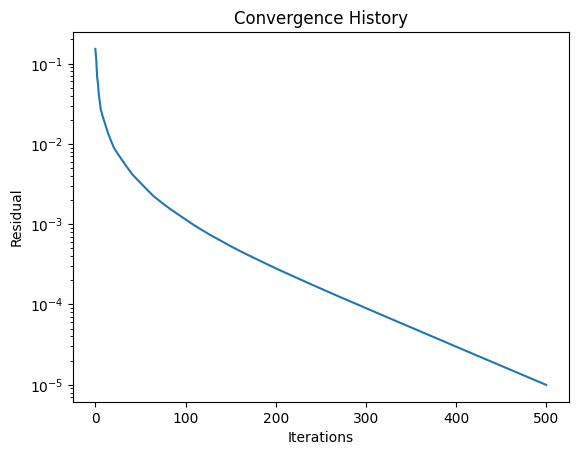

In [4]:
# Final residual        
print(f"Final Iteration = {iteration}; Residual = {max_res}")
plt.plot(np.arange(iteration)[0:-1], res_hist)
plt.xlabel("Iterations")
plt.ylabel("Residual")
plt.title("Convergence History")
# plt.grid()
ax = plt.gca()
ax.set_yscale("log")

## Visualization

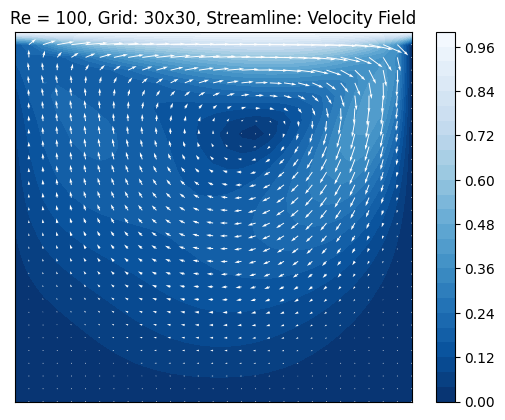

In [5]:
plt.figure()
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, np.sqrt(u[1:imax,:].T**2 + v[1:imax, 0:jmax].T**2), 32, cmap='Blues_r')
plt.colorbar()
plt.quiver(X, Y, u[1:imax,:].T, v[1:imax, 0:jmax].T, color='w')
plt.title('Re = {0}, Grid: {1}x{2}, Streamline: Velocity Field'.format(Re, imax, jmax))
plt.xticks([])
plt.yticks([])
plt.show()

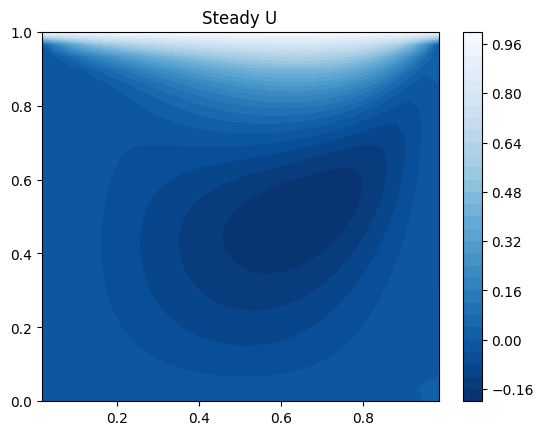

In [6]:
X, Y = np.meshgrid(x, y)
plt.figure()
plt.contourf(X, Y, u[1:imax,:].T, 32, cmap='Blues_r')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title("Steady U")
plt.show()

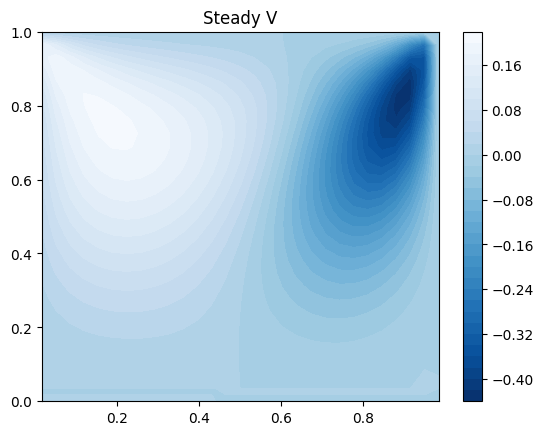

In [7]:
plt.figure()
X, Y = np.meshgrid(x, y)
plt.contourf(X, Y, v[1:imax, 0:jmax].T, 32, cmap='Blues_r')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title("Steady V")
plt.show()

## Benchmark with literature data

Ghia, U. K. N. G., Kirti N. Ghia, and C. T. Shin. "High-Re solutions for incompressible flow using the Navier-Stokes equations and a multigrid method." Journal of computational physics 48.3 (1982): 387-411.

### Re = 100

In [8]:
GhiaU = np.loadtxt('./GhiaU.txt', skiprows=1)
GhiaV = np.loadtxt('./GhiaV.txt', skiprows=1)
y_Ghia = GhiaU[:, 0]
x_Ghia = GhiaV[:, 0]

In [9]:
# Understand what's inside the benchmark data
import pandas as pd
# pd.set_option('display.max_columns', None)
df = pd.read_table("./GhiaU.txt", skiprows=0, delimiter='\r')
print(df)

   # Ghia, U. K. N. G., Ghia, K. N., & Shin, C. T. (1982). 
0   # High-Re solutions for incompressible flow us...      
1   # Journal of computational physics, 48(3), 387...      
2                                                   #      
3                                           # TABLE I      
4   # Results for $u$-velocity along Vertical Line...      
5   #---------------------------------------------...      
6              #                                   Re      
7   #       --------------------------------------...      
8   #  y      100      400      1000     3200     ...      
9   #---------------------------------------------...      
10  1.0000  1.00000  1.00000  1.00000  1.00000  1....      
11  0.9766  0.84123  0.75837  0.65928  0.53236  0....      
12  0.9688  0.78871  0.68439  0.57492  0.48296  0....      
13  0.9609  0.73722  0.61756  0.51117  0.46547  0....      
14  0.9531  0.68717  0.55892  0.46604  0.46101  0....      
15  0.8516  0.23151  0.29093  0.33304  0

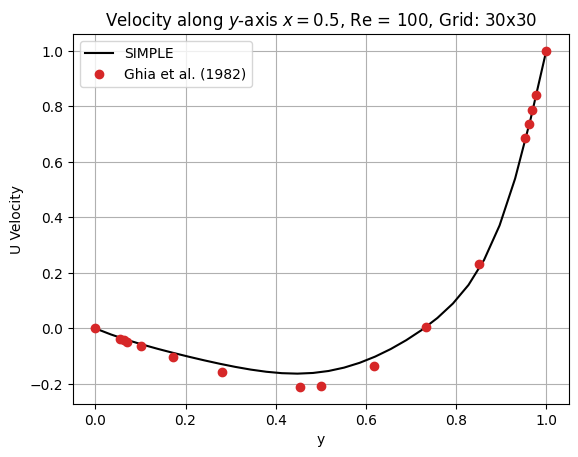

In [10]:
xmid_idx = int(imax/2-1)      # only works for even number
plt.plot(y, u[xmid_idx,:].T, 'k', label="SIMPLE")
plt.plot(y_Ghia, GhiaU[:, 1], 'o', color="tab:red", label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("y")
plt.ylabel("U Velocity")
plt.title("Velocity along $y$-axis $x=0.5$, Re = {0}, Grid: {1}x{2}".format(Re, imax, jmax))
plt.legend()

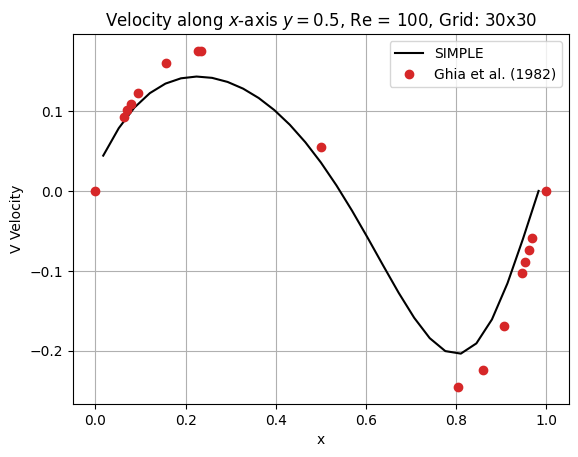

In [11]:
ymid_lidx = int(imax/2-1)      # only works for even number
v_profile = (v[1:imax, ymid_lidx].T + v[1:imax, ymid_lidx+1].T)/2
plt.plot(x, v_profile, 'k', label="SIMPLE")
plt.plot(x_Ghia, GhiaV[:, 1], 'o', color="tab:red", label = "Ghia et al. (1982)")
plt.grid()
plt.xlabel("x")
plt.ylabel("V Velocity")
plt.title("Velocity along $x$-axis $y=0.5$, Re = {0}, Grid: {1}x{2}".format(Re, imax, jmax))
plt.legend()

## Scaling analysis for matrix $A$

Ap Matrix Condition Number =  76518.47446407289


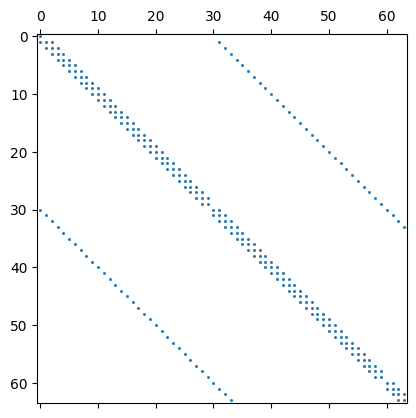

In [12]:
# Check sparse pattern
print("Ap Matrix Condition Number = ", np.linalg.cond(Ap))
plt.spy(Ap[0:64, 0:64], markersize=1)
plt.show()

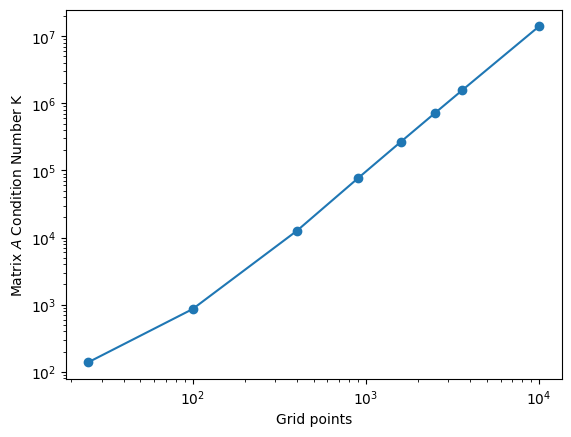

In [13]:
# Re = 100
grid_x = [25, 100, 400, 900, 1600, 2500, 3600, 10000]
kappa_y = [138.36447113962592, 858.277740606385, 12593.792724713172, 76343.70137631039, 269779.31285984936, 712447.8906674631, 1568100.674990764, 14045367.029215474]
plt.plot(grid_x, kappa_y, "o-")
plt.xlabel("Grid points")
plt.ylabel("Matrix $A$ Condition Number $Κ$")
# plt.grid()
ax = plt.gca()
ax.set_xscale("log")
ax.set_yscale("log")

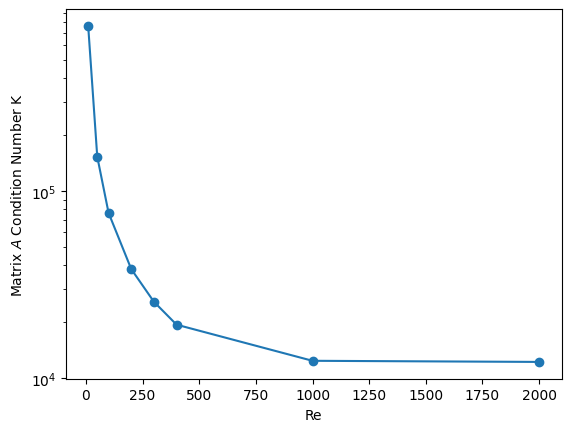

In [14]:
# 30x30 grid
Re_x = [10, 50, 100, 200, 300, 400, 1000, 2000]
kappa_y = [763067.6749285684, 152633.0089150649, 76343.70137631039, 38229.15155527901, 25562.329792539098, 19273.101238411968, 12353.77058950705, 12183.887620729089]
plt.plot(Re_x, kappa_y, "o-")
plt.xlabel("Re")
plt.ylabel("Matrix $A$ Condition Number $Κ$")
# plt.grid()
ax = plt.gca()
# ax.set_xscale("log")
ax.set_yscale("log")